In [2]:
import torch
import cv2

In [4]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('camera error...')
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print('frame camera error...')
        break

    cv2.imshow('web-camera', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [6]:
import shutil
import os
import zipfile

from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2

from typing import List
import csv

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class SignLanguageMNIST(Dataset):
    """Sign Language classification dataset.

    Each sample is 1 x 1 x 28 x 28, and each label is a scalar.
    """
    @staticmethod
    def get_label_mapping():
        """
        Из латинского алфавита без буквы Z дополнительно исключается буква J.
        """
        mapping = list(range(25))
        mapping.pop(9)
        return mapping

    @staticmethod
    def read_label_samples_from_csv(path: str):
        """
        Assumes first column in CSV is the label and subsequent 28^2 values
        are image pixel values 0-255.
        """
        mapping = SignLanguageMNIST.get_label_mapping()
        labels, samples = [], []
        with open(path) as f:
            _ = next(f)  # skip header
            for line in csv.reader(f):
                label = int(line[0])
                labels.append(mapping.index(label))
                samples.append(list(map(int, line[1:])))
        return labels, samples

    def __init__(self,
            path: str="sign_mnist_train.csv",
            mean: List[float]=[0.485],
            std: List[float]=[0.229]):
        """
        Args:
            path: Path to `.csv` file containing `label`, `pixel0`, `pixel1`...
        """
        labels, samples = SignLanguageMNIST.read_label_samples_from_csv(path)
        self._samples = np.array(samples, dtype=np.uint8).reshape((-1, 28, 28, 1))
        self._labels = np.array(labels, dtype=np.uint8).reshape((-1, 1))

        self._mean = mean
        self._std = std

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self._mean, std=self._std)])

        return {
            'image': transform(self._samples[idx]).float(),
            'label': torch.from_numpy(self._labels[idx]).float()
        }

In [10]:
def get_train_test_loaders(batch_size=32):
    trainset = SignLanguageMNIST('data/gestures/sign-language-mnist/sign_mnist_train.csv')
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = SignLanguageMNIST('data/gestures/sign-language-mnist/sign_mnist_test.csv')
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

In [11]:
loader, _ = get_train_test_loaders(2)
print(next(iter(loader)))

{'image': tensor([[[[ 0.6049,  0.6392,  0.6734,  ...,  0.7248,  0.7077,  0.7077],
          [ 0.6392,  0.6734,  0.6906,  ...,  0.7591,  0.7419,  0.7419],
          [ 0.6392,  0.6734,  0.7077,  ...,  0.7933,  0.7762,  0.7591],
          ...,
          [ 0.9646,  1.0159,  1.0673,  ...,  1.1015,  1.1187,  1.1015],
          [ 0.9474,  1.1015,  0.6049,  ...,  1.1358,  1.1187,  1.1187],
          [ 1.1015,  0.8104, -0.3198,  ...,  1.1187,  1.1358,  1.1187]]],


        [[[-0.2856, -0.1143, -0.0629,  ...,  0.6563,  0.6563,  0.6734],
          [-0.2342, -0.1143, -0.0629,  ...,  0.6906,  0.6906,  0.6734],
          [-0.2171, -0.1143, -0.0629,  ...,  0.7248,  0.7077,  0.7077],
          ...,
          [-1.0048, -0.7822, -0.6794,  ..., -0.7479, -0.7479, -0.7650],
          [-0.9192, -0.6965, -0.6109,  ..., -0.7308, -0.7308, -0.7822],
          [-0.8335, -0.7308, -0.6109,  ..., -0.7650, -0.7822, -0.7137]]]]), 'label': tensor([[23.],
        [ 7.]])}


Жест соответствует букве 'B'


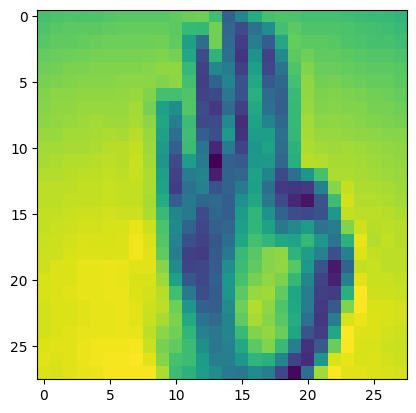

In [12]:
index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')
data = next(iter(loader))
labels = Variable(data['label'].long())
index = labels[:, 0].tolist()[0]
image = Variable(data['image'][0][0].float())
plt.imshow(image)
print(f"Жест соответствует букве '{index_to_letter[index]}'")

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 48)
        self.fc3 = nn.Linear(48, 24)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
epoch_losses = []

In [16]:
def train(net, criterion, optimizer, trainloader, epoch):
    global epoch_losses
    running_loss = 0.0
    epoch_loss = []

    for i, data in enumerate(trainloader, 0):
        inputs = Variable(data['image'].float())
        labels = Variable(data['label'].long())
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if i % 100 == 0:
            print('[%d, %5d] loss: %.6f' % (epoch, i, running_loss / (i + 1)))
    epoch_losses.append(epoch_loss)

In [18]:
def train_model():
    global epoch_losses
    net = Net().float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    trainloader, _ = get_train_test_loaders()
    epoch_losses.clear()

    for epoch in range(12):  # loop over the dataset multiple times
        train(net, criterion, optimizer, trainloader, epoch)
        scheduler.step()
    torch.save(net.state_dict(), "checkpoint.pth")

In [19]:
train_model()

[0,     0] loss: 3.167751
[0,   100] loss: 3.175939
[0,   200] loss: 3.111420
[0,   300] loss: 2.895011
[0,   400] loss: 2.660616
[0,   500] loss: 2.390054
[0,   600] loss: 2.139092
[0,   700] loss: 1.922981
[0,   800] loss: 1.745106
[1,     0] loss: 0.327967
[1,   100] loss: 0.386194
[1,   200] loss: 0.341883
[1,   300] loss: 0.314634
[1,   400] loss: 0.305891
[1,   500] loss: 0.283372
[1,   600] loss: 0.276876
[1,   700] loss: 0.262934
[1,   800] loss: 0.247335
[2,     0] loss: 0.071751
[2,   100] loss: 0.146017
[2,   200] loss: 0.153152
[2,   300] loss: 0.141954
[2,   400] loss: 0.138423
[2,   500] loss: 0.138857
[2,   600] loss: 0.134368
[2,   700] loss: 0.131279
[2,   800] loss: 0.127695
[3,     0] loss: 0.152495
[3,   100] loss: 0.090443
[3,   200] loss: 0.085325
[3,   300] loss: 0.077154
[3,   400] loss: 0.078323
[3,   500] loss: 0.072675
[3,   600] loss: 0.075287
[3,   700] loss: 0.075621
[3,   800] loss: 0.075057
[4,     0] loss: 0.136005
[4,   100] loss: 0.091796
[4,   200] l

Text(0.5, 1.0, 'losses vs. No. of epochs')

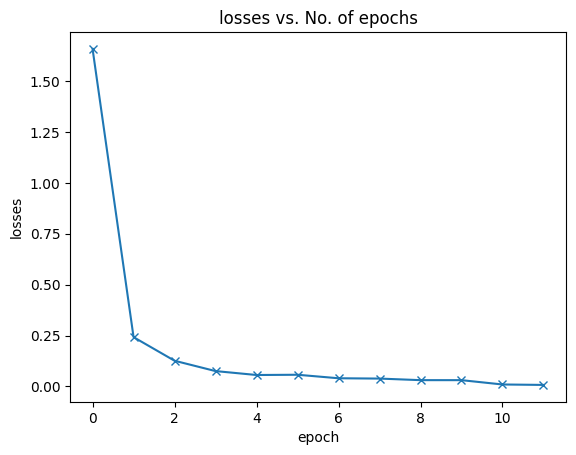

In [20]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [21]:
import onnx
import onnxruntime as ort

In [22]:
def evaluate(outputs: Variable, labels: Variable) -> float:
    """Evaluate neural network outputs against non-one-hotted labels."""
    Y = labels.numpy()
    Yhat = np.argmax(outputs, axis=1)
    return float(np.sum(Yhat == Y))


def batch_evaluate(
        net: Net,
        dataloader: torch.utils.data.DataLoader) -> float:
    """Evaluate neural network in batches, if dataset is too large."""
    score = n = 0.0
    for batch in dataloader:
        n += len(batch['image'])
        outputs = net(batch['image'])
        if isinstance(outputs, torch.Tensor):
            outputs = outputs.detach().numpy()
        score += evaluate(outputs, batch['label'][:, 0])
    return score / n


def validate():
    trainloader, testloader = get_train_test_loaders()
    net = Net().float().eval()

    pretrained_model = torch.load("checkpoint.pth")
    net.load_state_dict(pretrained_model)

    print('=' * 10, 'PyTorch', '=' * 10)
    train_acc = batch_evaluate(net, trainloader) * 100.
    print('Training accuracy: %.1f' % train_acc)
    test_acc = batch_evaluate(net, testloader) * 100.
    print('Validation accuracy: %.1f' % test_acc)

    trainloader, testloader = get_train_test_loaders(1)

    # export to onnx
    fname = "signlanguage.onnx"
    dummy = torch.randn(1, 1, 28, 28)
    torch.onnx.export(net, dummy, fname, input_names=['input'])

    # check exported model
    model = onnx.load(fname)
    onnx.checker.check_model(model)  # check model is well-formed

    # create runnable session with exported model
    ort_session = ort.InferenceSession(fname)
    net = lambda inp: ort_session.run(None, {'input': inp.data.numpy()})[0]

    print('=' * 10, 'ONNX', '=' * 10)
    train_acc = batch_evaluate(net, trainloader) * 100.
    print('Training accuracy: %.1f' % train_acc)
    test_acc = batch_evaluate(net, testloader) * 100.
    print('Validation accuracy: %.1f' % test_acc)

In [23]:
validate()

========== PyTorch ==========
Training accuracy: 99.8
Validation accuracy: 97.5
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

========== ONNX ==========
Training accuracy: 99.8
Validation accuracy: 97.6


In [24]:
def center_crop(frame):
    h, w, _ = frame.shape
    start = abs(h - w) // 2
    if h > w:
        frame = frame[start: start + w]
    else:
        frame = frame[:, start: start + h]
    return frame

In [25]:
def guess():
    # constants
    index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')

    # create runnable session with exported model
    ort_session = ort.InferenceSession("signlanguage.onnx")

    cap = cv2.VideoCapture(0)
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == False and frame is None:
            break

        # preprocess data
        frame = center_crop(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        x = cv2.resize(frame, (28, 28))
        x = x.reshape(1, 1, 28, 28).astype(np.float32)
        y = ort_session.run(None, {'input': x})[0]
        index = np.argmax(y, axis=1)                        # индекс символа, выраженного распознанным жестом
        letter = index_to_letter[int(index)]
        cv2.putText(frame, letter, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), thickness=2)

        cv2.imshow("Sign Language Translator", frame)       # Окно вывода в стиле Windows, 1-й параметр - заголовок

        if cv2.waitKey(1) & 0xFF == ord('q'):               # Окно закрывается только по нажатию 'q' малого
            break                                           # для закрытия по "крестику" или иным образом нужен отдельный код

    cap.release()
    cv2.destroyAllWindows()

In [26]:
guess()